## <span style="color:black">Описание проекта<span>

Анализ поведения пользователей в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

Цель состоит в том, чтобы пользователи дольше пользовались приложением, а также легче находили то, что им надо. 

Целевое событие - просмотр контактов.

Задачи: 
1. Анализ связей целевого события — просмотра контактов — и других действий пользователей. 
2. Какие действия чаще совершают те пользователи, которые просматривают контакты.

## <span style="color:black">Предобработка данных<span>

Замена названия столбцов на удобные, проверка пропусков, дубликатов и типов данных, редакция формата столбца с датами.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import datetime, timedelta
import math as mth
from scipy import stats as st
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
#прочитаем из csv-файла данные о клиентах
mobile_sources = pd.read_csv('/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('/datasets/mobile_dataset.csv')

#распечатаем их размер и первые 5 строк
for data in [mobile_sources, mobile_dataset]: print(data.shape)
for data in [mobile_sources, mobile_dataset]: display(data.head(5))

(4293, 2)
(74197, 3)


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [3]:
#какое количество пользователей в файле mobile_dataset:
mobile_dataset['user.id'].nunique()

4293

Количество пользователей совпадает в обоих файлах

In [4]:
# проверка пропусков, дубликатов и типов данных
for data in [mobile_sources, mobile_dataset]: 
    display (data.info())
    print('пропусков:', data.isna().sum())
    print('дубликатов:', data.duplicated().sum())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

пропусков: userId    0
source    0
dtype: int64
дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

пропусков: event.time    0
event.name    0
user.id       0
dtype: int64
дубликатов: 0


Пропусков и дубликатов нет, тип данных столбца с датой надо привести к формату timedate64.

In [5]:
#посмотрим названия событий и источников:
display (mobile_dataset['event.name'].unique())
display (mobile_sources['source'].unique())

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

array(['other', 'yandex', 'google'], dtype=object)

Есть 'show_contacts'и'contacts_show', два названия для целевого события. Вероятно, файл составляли из двух источников. Отредактируем этот момент, чтобы не запутаться дальше. Целевое событие будет только 'contacts_show'.

Так же есть семь событий поиска, но мы не имеем информации об их различиях. Поэтому, объединим все поиски в 'search'.

In [6]:
# заменим 'show_contacts' на 'contacts_show':
mobile_dataset.loc[mobile_dataset['event.name'] == 'show_contacts', 'event.name'] = 'contacts_show'

#объединим все поисковые запрос в один search
duplicates = ['search_4', 'search_5', 'search_1', 'search_2', 'search_3', 'search_6', 'search_7'] 
name = 'search' 

def replace_wrong_values(wrong_values, correct_value): # на вход функции подаются список неправильных значений и строка с правильным значением
    for wrong_value in wrong_values: 
        mobile_dataset['event.name'] = mobile_dataset['event.name'].replace(wrong_value, correct_value)  # и для каждого неправильного имени вызываем метод replace()
replace_wrong_values(duplicates, name) 

In [7]:
#редакция формата столбца с датами, соратим до секунд/ изменим тип данных в столбце, перевод времени в формат timedate64
mobile_dataset['event.time'] = pd.to_datetime (mobile_dataset['event.time'], format = '%Y-%m-%d %H:%M:%S.%f')
mobile_dataset['event.time'] = mobile_dataset['event.time'].dt.round ('1S')

In [8]:
# проверим пересечение по источникам
users_other = mobile_sources.loc[mobile_sources.loc[:,'source'] == 'other']['userId']
users_yandex = mobile_sources.loc[mobile_sources.loc[:,'source'] == 'yandex']['userId']
cross_users = mobile_sources.query('source == "yandex" and userId in @users_other') ['userId'].drop_duplicates()
cross_users_google = mobile_sources.query('source == "google" and userId in @users_other') ['userId'].drop_duplicates()
cross_users_google = mobile_sources.query('source == "google" and userId in @users_yandex') ['userId'].drop_duplicates()
print ('Обнаружено', len (cross_users), 'пересекающихся пользователя в группах other и yandex')
print ('Обнаружено', len (cross_users_google), 'пересекающихся пользователя в группах other, yandex и google')

Обнаружено 0 пересекающихся пользователя в группах other и yandex
Обнаружено 0 пересекающихся пользователя в группах other, yandex и google


In [9]:
# проверим пересечение по пользователям в обоих файлах:
users_sources = mobile_sources ['userId']
cross_users = mobile_dataset['user.id'].drop_duplicates()
print ('Обнаружено', len(cross_users), 'пересекающихся пользователя в файлах mobile_sources и mobile_dataset')

Обнаружено 4293 пересекающихся пользователя в файлах mobile_sources и mobile_dataset


Мы имеем информацию об одинаковых пользователях в обоих файлах. ПОэтому файлы можно будет объединить для удобства работы.

По источникам мы видим, что каждый клиент приходит только из одного источника. 

In [10]:
#изменим названия столбцов
mobile_sources.columns = ['user_id', 'source'] 
mobile_dataset.columns = ['event_time', 'event_name', 'user_id'] 

In [11]:
#объединим файлы
mobile_dataset = pd.merge(mobile_dataset,mobile_sources, on='user_id')

Вывод: 

есть данные о действиях 4293 пользователей в мобильном приложении и источники их перехода. Заменили названия столбцов для удобства работы. Пропусков, дубликатов нет. Тип данных заменили только в столбце с временем, также соратили дату до секунд. Проверили на пересекающихся пользователей по источникам, все хорошо, пересечений нет. Также проверили, что пользователи в двух файлах одинаковые. Тут тоже все хорошо. Уифицировали название целевого события и поисков.

## <span style="color:black">Исследовательский анализ данных<span>

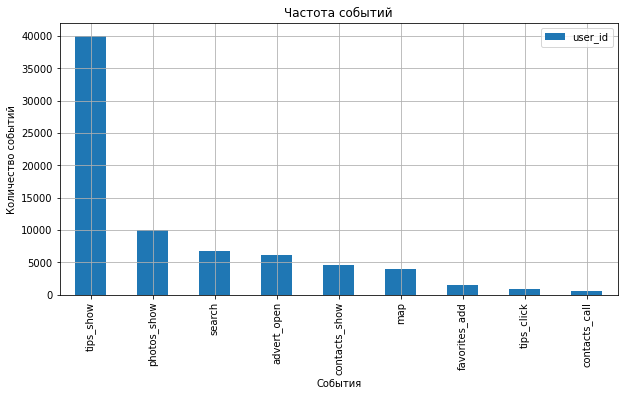

In [12]:
#Какие события есть в логах, как часто они встречаются? 
#диаграмма распределения количества событий по типу события
mobile_dataset.groupby('event_name').agg({'user_id':'count'}).sort_values(by = 'user_id', ascending=False).plot(kind='bar', grid = True, figsize = (10,5))
plt.xlabel('Cобытия')
plt.ylabel('Количество событий')
plt.title('Частота событий')
plt.show()

Самое распространенное событие  - это 'tips_show', но появление этого события не зависит от пользователя. Это реклама разных объявлений.
Человек может нажать на него и тогда мы получим событие tips_click. Поэтому для анализа поведения пользователя мы уберем из выборки это событие.

В первой тройке популярных событий: 'photos_show' 'search', 'advert_open'. Возможно корректней будет поставить поиск на первое место, потому что у объявлений обычно несколько фотографий. Скорее всего логика действий будет: поиск - открытие объявления - просмотр фотографий. Дальше может быть другой поиск, открытие контактов, просмотр карты, добавление в понравившиеся и так далее.

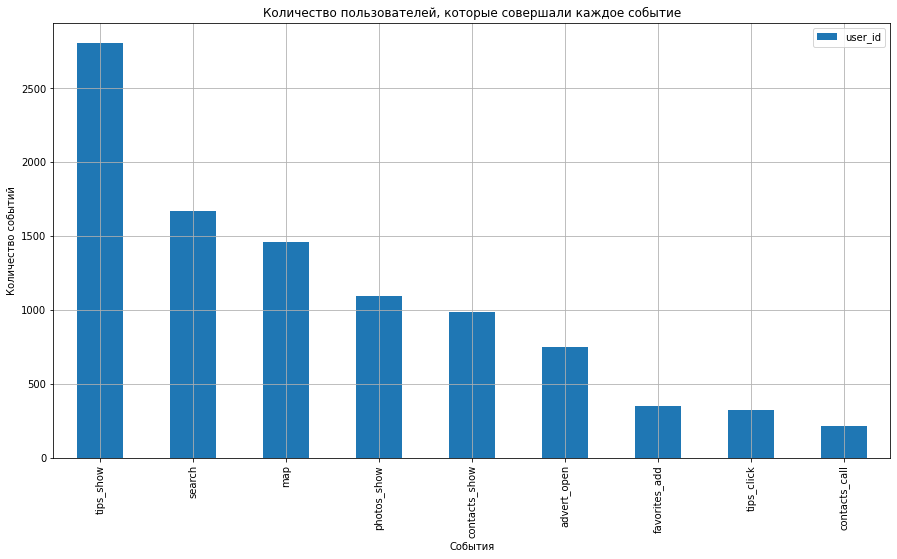

Доля пользователей, которые хоть раз совершали событие 1.51 %


In [13]:
#Сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 
mobile_dataset.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending=False).plot(kind='bar', grid = True, figsize = (15,8))
plt.xlabel('Cобытия')
plt.ylabel('Количество событий')
plt.title('Количество пользователей, которые совершали каждое событие')
plt.show()

#Посчитаем долю пользователей, которые хоть раз совершали событие.
a = mobile_dataset.groupby('user_id').agg({'event_name':'count'})
a = len (a.query('event_name == 1'))/mobile_dataset['user_id'].nunique()*100
print ('Доля пользователей, которые хоть раз совершали событие', round(a, 2),'%')

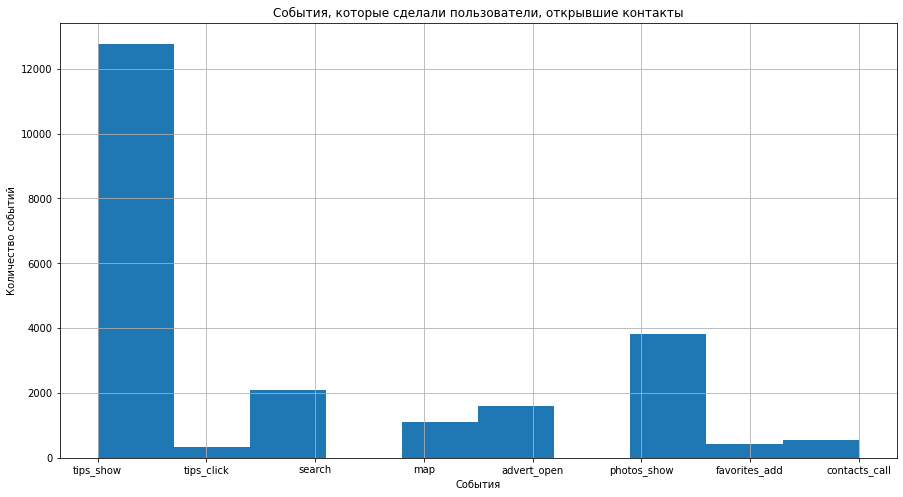

In [14]:
#Какие события часто совершают пользователи с целевым действием? Выделить основные сценарии использования приложения.
#определим пользователей, которые сделали целевое действие
users_contacts = mobile_dataset.loc[mobile_dataset.loc[:,'event_name'] == 'contacts_show']['user_id']
users_contacts_events = mobile_dataset.query('event_name != "contacts_show" and user_id in @users_contacts') ['event_name']
users_contacts_events.hist(grid = True, figsize = (15,8))
plt.xlabel('Cобытия')
plt.ylabel('Количество событий')
plt.title('Cобытия, которые сделали пользователи, открывшие контакты')
plt.show()

tips_show - это показ рекламного объявления и не требует от пользователя действий. Поэтому для анализа поведения мы сделаем отдельный файл без этого события.

Пользователи, которые открыли контакты, также смотрели фотографии, искали, открывали объявление и карту.

Наименее популярно - добавление в понравившиеся объявления и звонки. Возможно это связано со спецификой продукта. Ненужные вещи предлагают не постоянные товары, а скорее одноразовые предложения, поэтому откладывать на потом решение о покупке не имеет смысла.
Про звонки - возможно пользователю будет удобно посмотреть объявления на работу или в дороге, а позвонить сможет в удобное время.

In [15]:
# делаем выборку без tips_show
mobile_dataset_notips = mobile_dataset.query('event_name != "tips_show"')

In [16]:
#Сколько в среднем событий приходится на пользователя? 

c = mobile_dataset_notips.groupby('user_id').agg({'event_name':'count'}).mean().round()
c
print ('На пользователя в среднем', c[0], 'событий')
d = mobile_dataset_notips.groupby('user_id').agg({'event_name':'count'}).median().round()
print ('На пользователя медианна событий -', d[0])

На пользователя в среднем 10.0 событий
На пользователя медианна событий - 5.0


В файле данные за период с 2019-10-07 00:00:00 по 2019-11-03 23:56:57


<Figure size 1080x288 with 0 Axes>

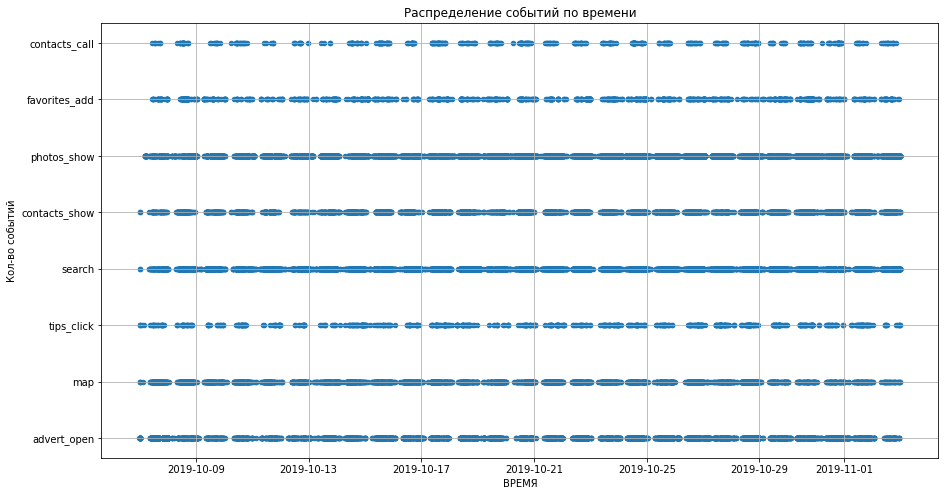

<Figure size 1080x288 with 0 Axes>

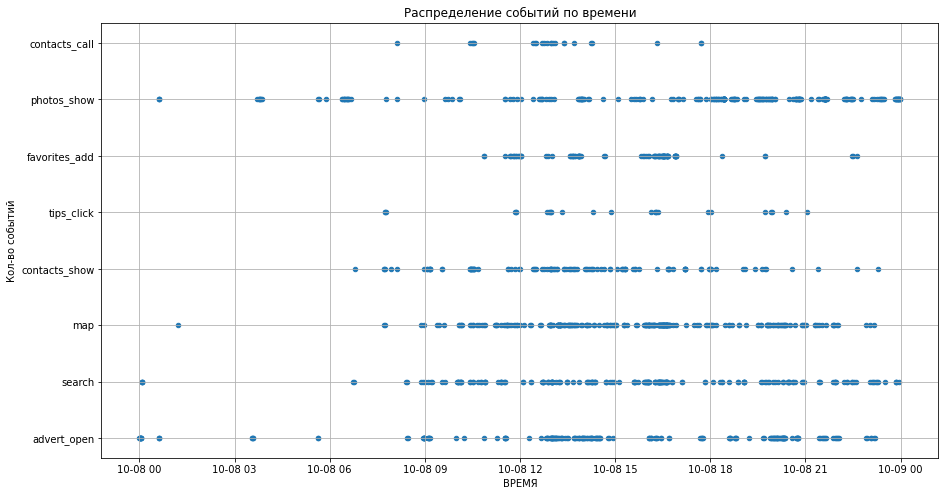

<Figure size 1080x288 with 0 Axes>

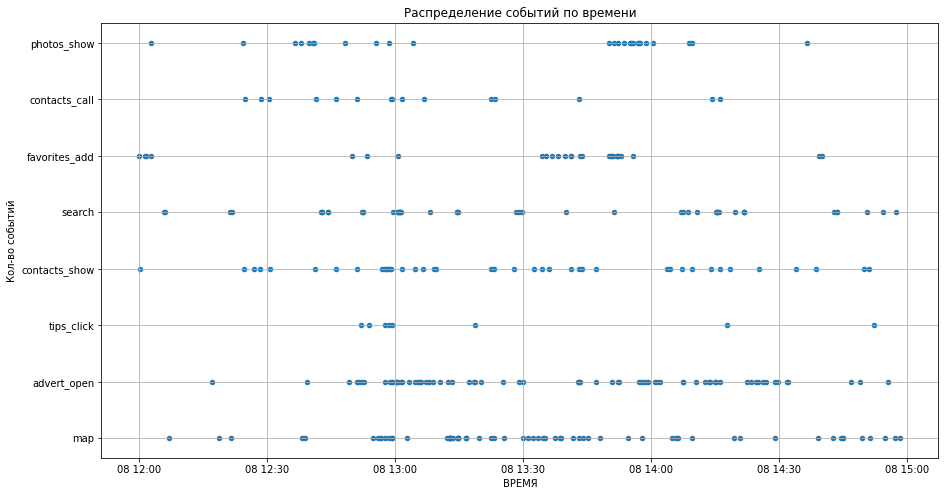

<Figure size 1080x288 with 0 Axes>

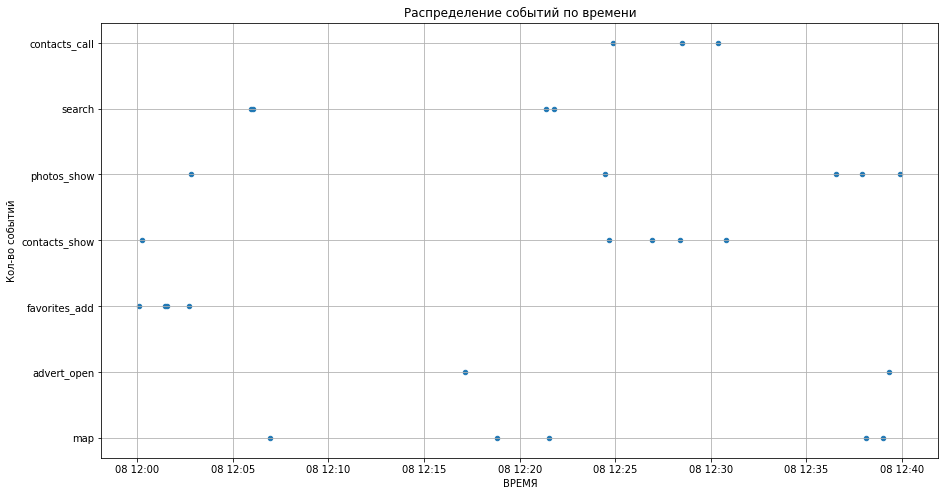

In [17]:
#Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. 
#Данными за какой период времени вы располагаете на самом деле?
print ('В файле данные за период с', mobile_dataset_notips['event_time'].min(),'по', mobile_dataset_notips['event_time'].max())

lim = (
    ['2019-10-07','2019-11-03'],
    ['2019-10-08','2019-10-09'],
    ['2019-10-08 12:00:00', '2019-10-08 15:00:00'],
    ['2019-10-08 12:00:00', '2019-10-08 12:40:00']
)

for period in lim:
    dt10m_per = mobile_dataset_notips[(mobile_dataset_notips['event_time'] >= period[0]) & (mobile_dataset_notips['event_time'] <= period[1])]
    plt.figure(figsize=(15,4))
    #sns.lineplot(data = dt10m_per,  x='event_time', y='event_name')
    dt10m_per.plot(x='event_time', y='event_name', kind='scatter' ,figsize = (15,8)) 
    plt.xlabel('ВРЕМЯ')
    plt.grid()
    plt.ylabel('Кол-во событий')
    plt.title('Распределение событий по времени');
    plt.show();

Вывод:

Пользователь имеет в среднем 10 событий или 5 событий по медиане. У нас есть некоторые выбросы (очень активные пользователи). 

Приложением чаще пользуются в период с 9 утра до 12 ночи и пик приходится на день (где-то с 12.00 до 18.00).

### <span style="color:black">Сессии<span>

In [18]:
#отсортируем события по пользователям
mobile_dataset_notips = mobile_dataset_notips.sort_values(['user_id', 'event_time'])
        
display(mobile_dataset_notips.head(5))

,event_time,event_name,user_id,source
2180,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
2181,2019-10-09 18:35:28,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
2186,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
2189,2019-10-21 19:56:49,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
2198,2019-10-22 11:18:15,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other


In [19]:
#пронумеруем строки:
mobile_dataset_notips['id']= np.arange(len(mobile_dataset_notips))[::-1]+1
mobile_dataset_notips.head(10)

,event_time,event_name,user_id,source,id
2180,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34142
2181,2019-10-09 18:35:28,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34141
2186,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34140
2189,2019-10-21 19:56:49,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34139
2198,2019-10-22 11:18:15,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34138
2202,2019-10-22 11:25:34,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34137
42960,2019-10-19 21:34:34,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34136
42961,2019-10-19 21:35:19,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34135
42962,2019-10-19 21:36:44,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34134
42963,2019-10-19 21:40:39,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34133


In [20]:
#В колонке 'diff' для каждого события отдельного пользователя посчитаем разницу между временем посещения страницы и времененем посещения предыдущей страницы. Если страница была первой для пользователя, то значение в колонке 'diff' будет NaT, т.к. нет предыдущего значения
mobile_dataset_notips['diff'] = mobile_dataset_notips.groupby('user_id')['event_time'].diff(1)
display (mobile_dataset_notips)

,event_time,event_name,user_id,source,id,diff
2180,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34142,NaT
2181,2019-10-09 18:35:28,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34141,0 days 00:01:32
2186,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34140,12 days 01:18:11
2189,2019-10-21 19:56:49,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34139,0 days 00:03:10
2198,2019-10-22 11:18:15,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34138,0 days 15:21:26
...,...,...,...,...,...,...
19029,2019-11-03 14:38:51,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,5,0 days 00:02:09
19031,2019-11-03 14:41:25,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,4,0 days 00:02:34
19033,2019-11-03 14:42:26,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,3,0 days 00:01:01
19044,2019-11-03 15:48:05,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2,0 days 01:05:39


In [21]:
#разделим сессии по достижению целевого действия:
mobile_dataset_notips.loc[mobile_dataset_notips['event_name'].shift(1) == 'contacts_show', "diff"] = 'NaT'
mobile_dataset_notips.fillna ('NaT')
mobile_dataset_notips.tail(5)

,event_time,event_name,user_id,source,id,diff
19029,2019-11-03 14:38:51,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,5,NaT
19031,2019-11-03 14:41:25,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,4,NaT
19033,2019-11-03 14:42:26,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,3,NaT
19044,2019-11-03 15:48:05,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2,NaT
19049,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,1,NaT


In [22]:
#вернем формат timedelta колонке diff
mobile_dataset_notips ['diff'] = pd.to_timedelta(mobile_dataset_notips ['diff'])

In [23]:
mobile_dataset_notips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34142 entries, 2180 to 19049
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   event_time  34142 non-null  datetime64[ns] 
 1   event_name  34142 non-null  object         
 2   user_id     34142 non-null  object         
 3   source      34142 non-null  object         
 4   id          34142 non-null  int64          
 5   diff        26511 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(3), timedelta64[ns](1)
memory usage: 1.8+ MB


In [24]:
#выделим следующее действие в отдельный столбец
mobile_dataset_notips['next_event'] = mobile_dataset_notips.groupby('user_id')['event_name'].shift(-1)
display(mobile_dataset_notips.head(20))

,event_time,event_name,user_id,source,id,diff,next_event
2180,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34142,NaT,map
2181,2019-10-09 18:35:28,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34141,0 days 00:01:32,map
2186,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34140,12 days 01:18:11,map
2189,2019-10-21 19:56:49,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34139,0 days 00:03:10,map
2198,2019-10-22 11:18:15,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34138,0 days 15:21:26,map
2202,2019-10-22 11:25:34,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34137,0 days 00:07:19,NaN
42960,2019-10-19 21:34:34,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34136,NaT,search
42961,2019-10-19 21:35:19,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34135,0 days 00:00:45,search
42962,2019-10-19 21:36:44,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34134,0 days 00:01:25,photos_show
42963,2019-10-19 21:40:39,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34133,0 days 00:03:55,photos_show


In [25]:
#посчитаем количество нулевых значений:
print ('Нулевых значений времени между событиями:', mobile_dataset_notips[mobile_dataset_notips.loc[:, 'diff'] == '0 days 00:00:00']['diff'].count())
display (mobile_dataset_notips[mobile_dataset_notips.loc[:, 'diff'] == '0 days 00:00:00'].head(5))
mobile_dataset_notips = mobile_dataset_notips[mobile_dataset_notips.loc[:, 'diff'] != '0 days 00:00:00']

#посмотрим на события длиной 26 дней.
display (mobile_dataset_notips[mobile_dataset_notips.loc[:, 'diff'] > '7 days 00:00:00'])
#удалим длинные события.
mobile_dataset_notips = mobile_dataset_notips[mobile_dataset_notips.loc[:, 'diff'] < '7 days 00:00:00']

#медиана разницы между событиями
print ('Время между событиями')
mobile_dataset_notips[mobile_dataset_notips.loc[:, 'diff'] != '0 days 00:00:00']['diff'].describe()

Нулевых значений времени между событиями: 893


,event_time,event_name,user_id,source,id,diff,next_event
44232,2019-10-22 20:49:43,photos_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,33984,0 days,search
49035,2019-10-22 13:02:27,map,007d031d-5018-4e02-b7ee-72a30609173f,yandex,33979,0 days,contacts_show
62901,2019-10-27 22:48:59,map,01a64bec-69b9-437b-9897-d47b47f3db78,other,33900,0 days,map
62902,2019-10-27 22:48:59,map,01a64bec-69b9-437b-9897-d47b47f3db78,other,33899,0 days,NaN
38260,2019-10-18 10:00:47,photos_show,01d283e1-cb1c-407a-a4e0-9f72f3deecca,google,33890,0 days,contacts_show


,event_time,event_name,user_id,source,id,diff,next_event
2186,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34140,12 days 01:18:11,map
8858,2019-10-18 23:13:32,map,02e7c193-842b-4995-b67a-8c87ac0f29bb,google,33839,10 days 02:10:31,map
7144,2019-10-28 10:09:12,search,04a1f108-5d99-4c71-a575-1f3290a507b9,google,33678,17 days 00:03:55,search
12266,2019-10-31 19:21:43,photos_show,06322fa8-a60f-486f-862c-df21ce5bbb83,yandex,33256,21 days 13:32:25,NaN
4637,2019-10-27 14:32:23,photos_show,063c0b06-6d9d-4580-8d03-f1c8f19ebfa1,other,33246,14 days 15:06:46,photos_show
...,...,...,...,...,...,...,...
14224,2019-10-20 16:33:39,search,fc2f68a1-765e-4f8b-8caf-2c49d68fea19,other,453,10 days 00:57:02,map
18046,2019-10-21 01:18:11,advert_open,fd33e787-85c8-4c53-99bd-3439f676fb40,other,271,9 days 05:42:41,advert_open
3374,2019-10-20 01:52:58,search,fd990f8f-cd18-4e67-bed4-517b1f6f2764,yandex,235,12 days 10:01:54,search
31524,2019-10-27 21:13:28,search,ff82c7c7-16d6-44b1-833b-a217747b0b02,yandex,106,11 days 21:00:04,search


Время между событиями


count                        25360
mean     0 days 04:01:34.931427444
std      0 days 17:26:12.261148966
min                0 days 00:00:01
25%                0 days 00:00:28
50%                0 days 00:01:23
75%                0 days 00:04:40
max                6 days 23:56:28
Name: diff, dtype: object

In [26]:
#За какое время до совершения целевого события совершаются вспомогательные события?
print ('Время перед целевым событием')
mobile_dataset_notips.loc[(mobile_dataset_notips.loc[:, 'event_name'] == 'contacts_show') & 
                          (mobile_dataset_notips.loc[:, 'diff'] != '0 days 00:00:00')]['diff'].describe()

Время перед целевым событием


count                         1514
mean     0 days 04:32:20.212681638
std      0 days 17:27:01.093562520
min                0 days 00:00:01
25%                0 days 00:00:54
50%                0 days 00:02:47
75%         0 days 00:13:46.500000
max                6 days 23:15:14
Name: diff, dtype: object

Время между событиями в среднем составляет чуть больше минуты, а перед целевым событием почти 3 минуты. Получается почтти 2 минуты дополнительно идет на принятие решения о товаре.

Если мы рассмотрим сессию как набор медианы количества событий на пользователя и умножим на медиану времени между событиями, 10 событий * 2 - 3 минуты, то получится примерно 30 минут. 

In [27]:
#зададим размер сессии в 30 минут 
sessions_start_df = mobile_dataset_notips[(mobile_dataset_notips['diff'].isnull()) | (mobile_dataset_notips['diff'] > '30Min')]

sessions_start_df.head(10)

,event_time,event_name,user_id,source,id,diff,next_event
2198,2019-10-22 11:18:15,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,34138,0 days 15:21:26,map
42969,2019-10-20 18:49:24,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34127,0 days 20:49:29,photos_show
42987,2019-10-24 10:50:40,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34109,3 days 14:45:04,photos_show
42996,2019-10-29 21:18:25,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34100,5 days 10:21:12,photos_show
43016,2019-10-30 07:50:46,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34080,0 days 09:40:20,photos_show
40696,2019-10-20 17:47:19,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,34052,1 days 19:29:38,search
40701,2019-10-25 22:17:32,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,34048,5 days 04:29:50,search
40705,2019-10-26 23:34:22,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,34044,1 days 00:48:32,search
40710,2019-10-27 00:07:33,map,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,34042,0 days 00:33:09,advert_open
40716,2019-10-27 20:18:09,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,34036,0 days 20:05:57,search


In [28]:
sessions_start_df['session_id'] = sessions_start_df['id']

In [29]:
#С помощью функции merge_asof объединим между собой данные основного и вспомогательного датафреймов
mobile_dataset_notips = mobile_dataset_notips.sort_values('id')
sessions_start_df = sessions_start_df.sort_values('id')
mobile_dataset_notips = pd.merge_asof(mobile_dataset_notips,sessions_start_df[['id','user_id','session_id']],on='id',by='user_id')

In [30]:
mobile_dataset_notips.tail(20)

,event_time,event_name,user_id,source,id,diff,next_event,session_id
25340,2019-10-20 19:18:55,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34119,0 days 00:01:30,photos_show,34109.0
25341,2019-10-20 19:17:19,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34121,0 days 00:05:32,contacts_call,34109.0
25342,2019-10-20 19:11:47,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34122,0 days 00:01:51,contacts_show,34109.0
25343,2019-10-20 19:09:56,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34123,0 days 00:05:40,search,34109.0
25344,2019-10-20 19:04:16,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34124,0 days 00:01:14,search,34109.0
25345,2019-10-20 19:03:02,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34125,0 days 00:03:39,search,34109.0
25346,2019-10-20 18:59:23,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34126,0 days 00:09:59,favorites_add,34109.0
25347,2019-10-20 18:49:24,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34127,0 days 20:49:29,photos_show,34127.0
25348,2019-10-19 21:59:55,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34128,0 days 00:01:55,search,34127.0
25349,2019-10-19 21:58:00,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34129,0 days 00:11:07,photos_show,34127.0


In [31]:
print ('Количество пользователей: {0}'.format(mobile_dataset_notips['user_id'].nunique()))
print ('Количество сессий: {0}'.format(mobile_dataset_notips['session_id'].nunique()))
print ('Количество просмотров страниц: {0}'.format(mobile_dataset_notips['event_name'].count()))
print ('Среднее время просмотра страницы: {0}'.format(mobile_dataset_notips['diff'].mean()))

Количество пользователей: 2977
Количество сессий: 3308
Количество просмотров страниц: 25360
Среднее время просмотра страницы: 0 days 04:01:34.931427444


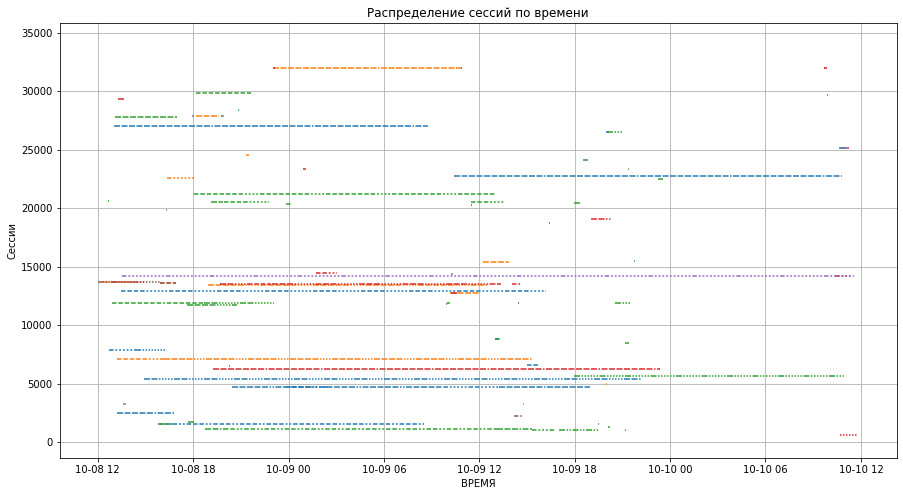

In [32]:
#гистограмма сессий
period = ['2019-10-08 12:00:00', '2019-10-10 12:00:00']
plt.figure(figsize=(15,8))
sns.lineplot(
    data= mobile_dataset_notips[(mobile_dataset_notips['event_time'] >= period[0]) & (mobile_dataset_notips['event_time'] <= period[1])],
    x="event_time", y="session_id", hue="event_name", style = 'session_id', legend = False)
plt.xlabel('ВРЕМЯ')
plt.grid()
plt.ylabel('Сессии')
plt.title('Распределение сессий по времени');
plt.show();


На гистограмме распределение сессий за период ['2019-10-08 12:00:00', '2019-10-10 12:00:00'], это двое суток, но мы не наблюдаем определенное цепочки действий / воронки. Либо сессия составляет более долгий период, либо воронки вообще нет и пользователь имеет множество путей достижения целевого события. 

График событий за недельный период по пользователям и времени также показывает отсутвие четкой воронки действий.

In [33]:
#выделим номера успешных сессий
good_session = mobile_dataset_notips.loc[mobile_dataset_notips.loc[:, 'event_name'] == 'contacts_show']['session_id']
#сохраним успешые сессии в отдельный файл
show = mobile_dataset_notips.query('session_id in @good_session')
show

,event_time,event_name,user_id,source,id,diff,next_event,session_id
0,2019-10-16 12:57:41,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,68,4 days 11:48:52,contacts_show,68.0
1,2019-10-12 01:08:49,map,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,69,0 days 00:00:55,contacts_show,68.0
2,2019-10-28 07:17:53,photos_show,ffe68f10-e48e-470e-be9b-eeb93128ff1a,yandex,71,0 days 00:02:43,NaN,NaN
3,2019-10-28 07:15:10,photos_show,ffe68f10-e48e-470e-be9b-eeb93128ff1a,yandex,72,0 days 00:00:49,photos_show,NaN
4,2019-10-28 07:14:21,photos_show,ffe68f10-e48e-470e-be9b-eeb93128ff1a,yandex,73,0 days 00:01:17,photos_show,NaN
...,...,...,...,...,...,...,...,...
25343,2019-10-20 19:09:56,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34123,0 days 00:05:40,search,34109.0
25344,2019-10-20 19:04:16,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34124,0 days 00:01:14,search,34109.0
25345,2019-10-20 19:03:02,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34125,0 days 00:03:39,search,34109.0
25346,2019-10-20 18:59:23,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,34126,0 days 00:09:59,favorites_add,34109.0


In [34]:
#выделим в отдельный файл номера сессий и события в них, чтобы попробовать найти некоторую последовательность действий:
session_list = show.pivot_table(index='session_id', values='event_name', aggfunc='sum').reset_index()
session_list

,session_id,event_name
0,68.0,contacts_showmap
1,80.0,contacts_showphotos_showsearch
2,114.0,contacts_showphotos_show
3,193.0,searchcontacts_show
4,199.0,contacts_showtips_clickmapsearchsearch
...,...,...
548,33886.0,contacts_showcontacts_show
549,33962.0,contacts_showsearch
550,34020.0,photos_showcontacts_showcontacts_show
551,34080.0,searchphotos_showadvert_opencontacts_showphoto...


In [35]:
print(session_list['event_name'].value_counts().head(30))

contacts_show                                                                                 111
searchcontacts_show                                                                            22
contacts_showsearch                                                                            13
contacts_showcontacts_show                                                                     12
contacts_showphotos_show                                                                       12
contacts_showmap                                                                               10
photos_showcontacts_show                                                                        9
contacts_showphotos_showphotos_show                                                             9
searchcontacts_showsearch                                                                       8
contacts_showsearchsearch                                                                       7
contacts_showcontact

In [36]:
#у нас много сессий с одним целевым действием. Посмотрим источник этих пользователей:
f = session_list[session_list.loc[:,'event_name'] == 'contacts_show']
f = pd.merge(f,show[['session_id','source']], on='session_id')
f['source'].value_counts()

yandex    41
other     38
google    32
Name: source, dtype: int64

Вывод:

Пользователи имеют как самостоятельные события, так и пары связанных событий, например просмотр фотографий и открытие контактов. У них есть множество путей и комбинаций событий в приложении. 
Поэтому мы можем рассмотреть влияние одного события на последующее. Например, событий просмотра фотографий приводят к целевому событию и другим действиям. 
Мы также видим, что пользователь иметь несколько сессий, но они состоят только из пары действий. 

Фотографии - в сессиях мы видим одно - два события. Возможно, здесь есть что улучшить. Больше фотографий и, возможно более детальных, может заинтересовать пользователя в продукте.

Favorites_add - при достаточно больших периодах поиска было бы удобнее добавлять объявления в отдельный список, чтобы было легче вернуться к ним. Но это событие почти не используется. Возможно, его можно улучшить, сделать более заметным и удобным.

### <span style="color:black">Воронки/конверсия событий<span>

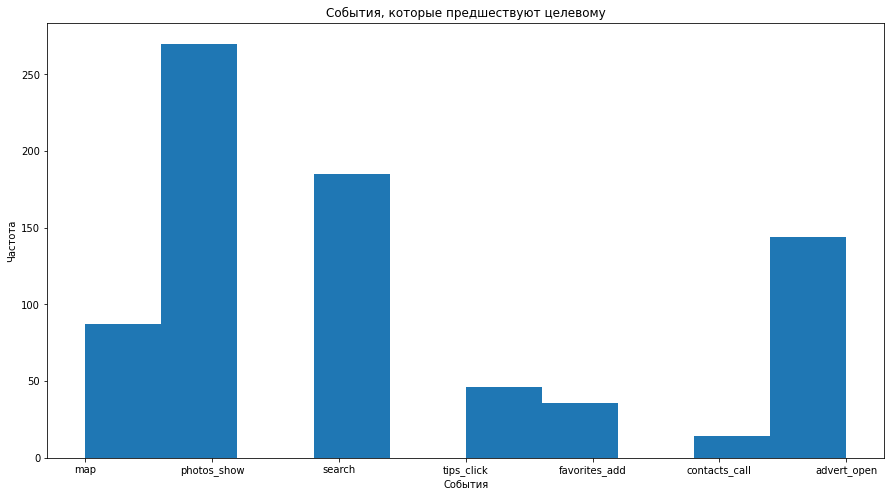

In [37]:
#какое событие предшествует целевому?
events_before = show.loc[(show.loc[:, 'next_event'] == 'contacts_show') & (show['event_name'] != 'contacts_show')]['event_name']
plt.figure(figsize=(15,8))
events_before.hist()
plt.xlabel('События')
plt.grid()
plt.ylabel('Частота')
plt.title('События, которые предшествуют целевому');
plt.show();

Перед целевым событием пользователи часто смотрят фотографии и делают поиск.

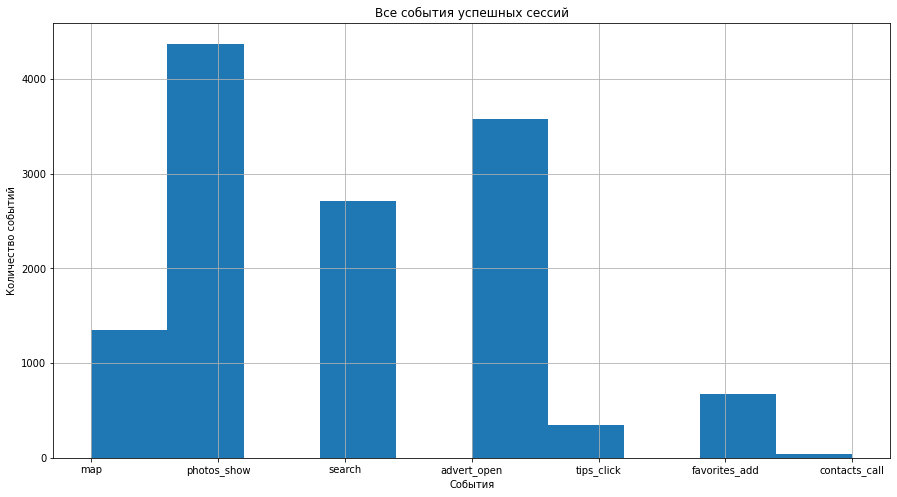

In [38]:
#какие события чаще встречаются в уcпешных сессиях:
events = show [(show['event_name'] != 'contacts_show')]['event_name']
events.hist(grid = True, figsize = (15,8))
plt.xlabel('Cобытия')
plt.ylabel('Количество событий')
plt.title('Все события успешных сессий')
plt.show()

In [39]:
events_before
events_before = show.loc[(show.loc[:, 'next_event'] == 'contacts_show') & (show['event_name'] != 'contacts_show')]['event_name']
users_before = show.loc[(show.loc[:, 'next_event'] == 'contacts_show') & (show['event_name'] != 'contacts_show')][['user_id', 'event_name']]

Для успешных сессий характерно производить поиск, открытие объявления, просмотр фотографий и карты.

In [40]:
#конверсия событий в целевое событие:
users_before = users_before.pivot_table(index='event_name', values='user_id', aggfunc='nunique').reset_index()
users_before
all_events = mobile_dataset_notips.pivot_table(index='event_name', values='user_id', aggfunc='nunique').reset_index()
all_events
events_conversion = pd.merge(users_before,all_events, on='event_name')
events_conversion ['conversion%'] = round((events_conversion ['user_id_x']/events_conversion['user_id_y']*100), 2)
events_conversion.columns = ['event_name', 'successful_users', 'total_users', 'conversion%']
print ('Конверсия событий в целевое событие')
display (events_conversion)

Конверсия событий в целевое событие


,event_name,successful_users,total_users,conversion%
0,advert_open,79,728,10.85
1,contacts_call,12,29,41.38
2,favorites_add,31,293,10.58
3,map,71,840,8.45
4,photos_show,182,1038,17.53
5,search,133,1437,9.26
6,tips_click,41,228,17.98


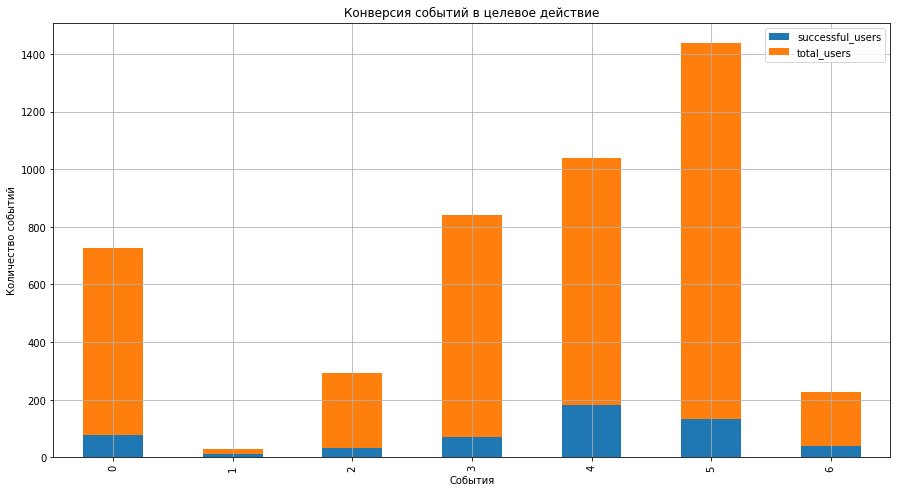

In [41]:
e = events_conversion[['event_name', 'successful_users', 'total_users']]
e['total_users'] = e['total_users']-e['successful_users']
e.plot.bar(grid = True, figsize = (15,8), stacked = True)
plt.xlabel('Cобытия')
plt.ylabel('Количество событий')
plt.title('Конверсия событий в целевое действие')
plt.show()

Наибольшая конверсия в целевое событие у contacts_call, tips_click, photos_show.

Меня немного смущает contacts_call в этом списке. Если пользователь уже решил позвонить продавцу, то зачем он потом переходит в его контакты. Они бы и так сохранились в телефоне. Возможно, здесь есть какая-то техническая ситуация и звонок не произошел, поэтому каждый пятый раз, пользователь переходит в контакты. Это необходимо проверить, если звонок действительно не удался, то может быть потерей половины покупателей.

In [42]:
#посмотрим зависимость событий друг от друга, для уcпешных сессий, в которых было целевое событие
list_of_events = ['advert_open', 'map', 'contacts_show', 'search', 'tips_click', 'photos_show', 'favorites_add', 'contacts_call']

#функция для расчет коневерсии в успешных сессиях:
def events_before_conversion (event):
    h = show [show['next_event'] == event][['event_name', 'user_id']]
    h = h.pivot_table(index='event_name', values='user_id', aggfunc='nunique')
    h = pd.merge(h,all_events ,on='event_name')
    h ['conversion%'] = round((h['user_id_x']/h['user_id_y']*100), 2)
    h.columns = ['event_name', 'successful_users', 'total_users', 'conversion%']
    print ('Конверсия событий в событие', event) 
    display (h)

In [43]:
#Составить воронки событий.
for event in list_of_events:
    events_before_conversion (event)

Конверсия событий в событие advert_open


,event_name,successful_users,total_users,conversion%
0,advert_open,475,728,65.25
1,contacts_show,54,726,7.44
2,favorites_add,33,293,11.26
3,map,167,840,19.88
4,photos_show,25,1038,2.41
5,search,118,1437,8.21
6,tips_click,15,228,6.58


Конверсия событий в событие map


,event_name,successful_users,total_users,conversion%
0,advert_open,91,728,12.50
1,contacts_show,58,726,7.99
2,favorites_add,10,293,3.41
3,map,203,840,24.17
4,search,173,1437,12.04
5,tips_click,22,228,9.65


Конверсия событий в событие contacts_show


,event_name,successful_users,total_users,conversion%
0,advert_open,79,728,10.85
1,contacts_call,12,29,41.38
2,contacts_show,307,726,42.29
3,favorites_add,31,293,10.58
4,map,71,840,8.45
5,photos_show,182,1038,17.53
6,search,133,1437,9.26
7,tips_click,41,228,17.98


Конверсия событий в событие search


,event_name,successful_users,total_users,conversion%
0,advert_open,86,728,11.81
1,contacts_call,3,29,10.34
2,contacts_show,79,726,10.88
3,favorites_add,23,293,7.85
4,map,80,840,9.52
5,photos_show,194,1038,18.69
6,search,636,1437,44.26
7,tips_click,1,228,0.44


Конверсия событий в событие tips_click


,event_name,successful_users,total_users,conversion%
0,advert_open,17,728,2.34
1,contacts_show,29,726,3.99
2,favorites_add,2,293,0.68
3,map,19,840,2.26
4,photos_show,1,1038,0.10
5,search,15,1437,1.04
6,tips_click,61,228,26.75


Конверсия событий в событие photos_show


,event_name,successful_users,total_users,conversion%
0,advert_open,31,728,4.26
1,contacts_call,9,29,31.03
2,contacts_show,117,726,16.12
3,favorites_add,67,293,22.87
4,photos_show,632,1038,60.89
5,search,247,1437,17.19


Конверсия событий в событие favorites_add


,event_name,successful_users,total_users,conversion%
0,advert_open,11,728,1.51
1,contacts_call,1,29,3.45
2,contacts_show,29,726,3.99
3,favorites_add,91,293,31.06
4,map,9,840,1.07
5,photos_show,62,1038,5.97
6,search,49,1437,3.41
7,tips_click,4,228,1.75


Конверсия событий в событие contacts_call


,event_name,successful_users,total_users,conversion%
0,contacts_call,4,29,13.79
1,contacts_show,170,726,23.42


In [44]:
#Какая доля пользователей доходит от первого события до просмотра контактов?
j = mobile_dataset_notips[mobile_dataset_notips['event_name'] == 'contacts_show']['user_id'].nunique()
i = j / mobile_dataset_notips ['session_id'].nunique() *100 
print ('Доля пользователей, которая доходит от первого события до просмотра контактов', round(i, 2),'%' )

Доля пользователей, которая доходит от первого события до просмотра контактов 21.95 %


В таблицах выше мы можем видеть какая доля пользователей переходит к следующему действию:

В advert_open переходят часто из advert_open, map, favourites add. 

В map из map, search, advert_open

В search из search, contact_show, photos.  Переход от звонка снова в поиск может быть, если не договорились с продавцом или не дозвонились.

tips_click из tips_click. Здесь надо учитывать еще tips_show, которое мы убрали из выборки. 

В photos из photos, call, favourites, search. 

В favourites add из favourites, photos и contacts_show.

В contacts_call из contacts_call, contacts_show

Очень низкая конверсия у событий favorites_add, map, tips_click. Возможно, эти события можно сделать более удобными для пользователя.

### <span style="color:black">Retention rate<span>

Расчет удержания для всей выборки по неделям

In [45]:
# здесь мы задаем текущую дату события в формате недели
mobile_dataset['active_date'] = mobile_dataset['event_time'].astype('datetime64[W]')

#добавляем столбец success для успешных пользователей:
mobile_dataset ['success'] = mobile_dataset['user_id'].isin (users_contacts)

# cгруппируем и найдем первый заход для каждого id
first_ts = mobile_dataset.groupby('user_id').agg({'event_time': 'min'}).reset_index()

In [46]:
first_ts = first_ts.rename(columns={'event_time':'first_ts'})
first_ts['first_ts'] = first_ts['first_ts'].astype('datetime64[W]')
# объеденяем датасеты
mobile_dataset = first_ts.merge(mobile_dataset, on = 'user_id')

In [47]:
# здесь рассчитываем lifetime события относительно первого захода пользователя
mobile_dataset['lifetime'] = mobile_dataset['active_date'] - mobile_dataset['first_ts']

# строим таблицу удержания
result_grouped = mobile_dataset.pivot_table(
    index=['first_ts'], columns='lifetime', values='user_id', aggfunc='nunique'
)
# вычисляем размеры когорт
cohort_sizes = (
    mobile_dataset.groupby('first_ts')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

# объединяем размеры когорт и таблицу удержания
result_grouped = cohort_sizes.merge(
    result_grouped, on='first_ts', how='left'
)

#вывести результат result_grouped в процентах. т.е. поделить все значения на cohort_size
result_grouped.columns = ['cohort_size', '0_%', '1_week_%', '2_weeks_%', '3_weeks_%', '4_weeks_%']


result_grouped ['1_week_%'] = result_grouped ['1_week_%']/result_grouped ['cohort_size']
result_grouped ['2_weeks_%'] = result_grouped ['2_weeks_%']/result_grouped ['cohort_size']
result_grouped ['3_weeks_%'] = result_grouped ['3_weeks_%']/result_grouped ['cohort_size']
result_grouped ['4_weeks_%'] = result_grouped ['4_weeks_%']/result_grouped ['cohort_size']

result_grouped


,cohort_size,0_%,1_week_%,2_weeks_%,3_weeks_%,4_weeks_%
first_ts,,,,,,
2019-10-03,547,547.0,0.270567,0.168190,0.109689,0.071298
2019-10-10,1120,1120.0,0.233929,0.154464,0.070536,NaN
2019-10-17,1136,1136.0,0.240317,0.088908,NaN,NaN
2019-10-24,1014,1014.0,0.173570,NaN,NaN,NaN
2019-10-31,476,476.0,NaN,NaN,NaN,NaN


Расчет удержания для успешных пользователей

In [48]:
good_users_events = mobile_dataset.query('success == True')
good_users_events=good_users_events.drop(columns=['first_ts'])
# здесь мы задаем текущую дату события в формате недели
good_users_events['active_date'] = good_users_events['event_time'].astype('datetime64[W]')

# cгруппируем и найдем первый заход для каждого id
first_ts = good_users_events.groupby('user_id').agg({'event_time': 'min'}).reset_index()
good_users_events

,user_id,event_time,event_name,source,active_date,success,lifetime
35,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,search,yandex,2019-10-17,True,0 days
36,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:35:19,search,yandex,2019-10-17,True,0 days
37,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:36:44,search,yandex,2019-10-17,True,0 days
38,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:40:39,photos_show,yandex,2019-10-17,True,0 days
39,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:42:14,photos_show,yandex,2019-10-17,True,0 days
...,...,...,...,...,...,...,...
74192,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 15:51:24,tips_show,google,2019-10-31,True,21 days
74193,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 15:51:58,contacts_show,google,2019-10-31,True,21 days
74194,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 16:07:41,tips_show,google,2019-10-31,True,21 days
74195,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 16:08:18,tips_show,google,2019-10-31,True,21 days


In [49]:
first_ts = first_ts.rename(columns={'event_time':'first_ts'})
first_ts['first_ts'] = first_ts['first_ts'].astype('datetime64[W]')
# объеденяем датасеты
good_users_events = first_ts.merge(good_users_events, on = 'user_id')
good_users_events

,user_id,first_ts,event_time,event_name,source,active_date,success,lifetime
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-17,2019-10-19 21:34:34,search,yandex,2019-10-17,True,0 days
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-17,2019-10-19 21:35:19,search,yandex,2019-10-17,True,0 days
2,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-17,2019-10-19 21:36:44,search,yandex,2019-10-17,True,0 days
3,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-17,2019-10-19 21:40:39,photos_show,yandex,2019-10-17,True,0 days
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-17,2019-10-19 21:42:14,photos_show,yandex,2019-10-17,True,0 days
...,...,...,...,...,...,...,...,...
27192,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-10,2019-11-03 15:51:24,tips_show,google,2019-10-31,True,21 days
27193,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-10,2019-11-03 15:51:58,contacts_show,google,2019-10-31,True,21 days
27194,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-10,2019-11-03 16:07:41,tips_show,google,2019-10-31,True,21 days
27195,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-10,2019-11-03 16:08:18,tips_show,google,2019-10-31,True,21 days


In [50]:
# здесь рассчитываесмя lifetime события относительно первого захода пользователя
good_users_events['lifetime'] = good_users_events['active_date'] - good_users_events['first_ts']

# строим таблицу удержания
show_result_grouped = good_users_events.pivot_table(
    index=['first_ts'], columns='lifetime', values='user_id', aggfunc='nunique'
)
# вычисляем размеры когорт
cohort_sizes = (
    good_users_events.groupby('first_ts')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

# объединяем размеры когорт и таблицу удержания
show_result_grouped = cohort_sizes.merge(
    show_result_grouped, on='first_ts', how='left'
)

#вывести результат result_grouped в процентах. т.е. поделить все значения на cohort_size
show_result_grouped.columns = ['cohort_size', '0_%', '1_week_%', '2_weeks_%', '3_weeks_%', '4_weeks_%']


show_result_grouped ['1_week_%'] = show_result_grouped ['1_week_%']/show_result_grouped ['cohort_size']
show_result_grouped ['2_weeks_%'] =show_result_grouped ['2_weeks_%']/show_result_grouped ['cohort_size']
show_result_grouped ['3_weeks_%'] = show_result_grouped ['3_weeks_%']/show_result_grouped ['cohort_size']
show_result_grouped ['4_weeks_%'] = show_result_grouped ['4_weeks_%']/show_result_grouped ['cohort_size']

show_result_grouped

,cohort_size,0_%,1_week_%,2_weeks_%,3_weeks_%,4_weeks_%
first_ts,,,,,,
2019-10-03,140,140.0,0.378571,0.307143,0.178571,0.107143
2019-10-10,233,233.0,0.364807,0.236052,0.128755,NaN
2019-10-17,269,269.0,0.330855,0.141264,NaN,NaN
2019-10-24,236,236.0,0.330508,NaN,NaN,NaN
2019-10-31,103,103.0,NaN,NaN,NaN,NaN


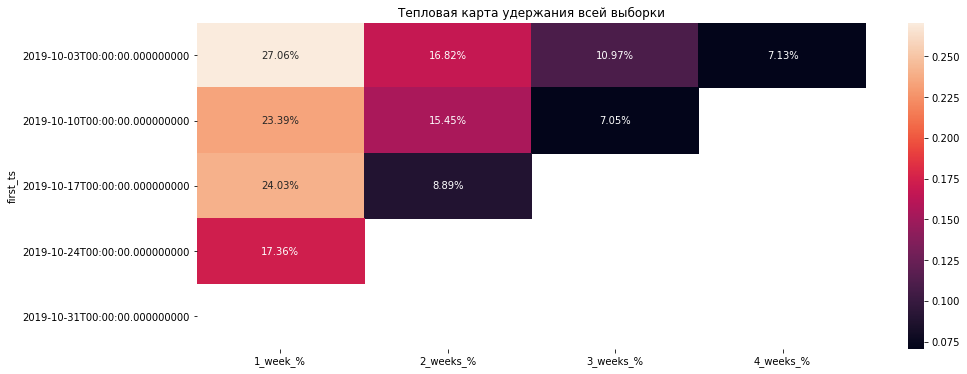

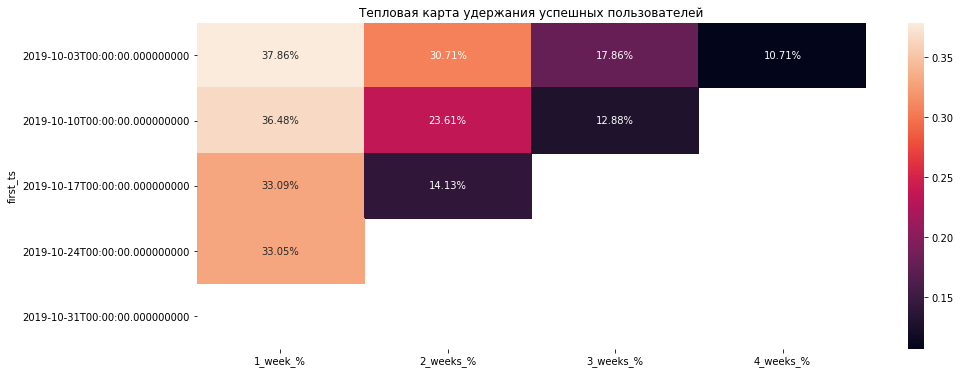

In [51]:
# строим хитмэп

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    result_grouped.drop(columns=['cohort_size', '0_%']),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания всей выборки')  # название графика

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    show_result_grouped.drop(columns=['cohort_size', '0_%']),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания успешных пользователей')  # название графика



plt.show()


Графики удержания показывают ,что в приложении удержание хорошее. Успешные пользователи больше остаются с приложением. Поэтому надо помогать клиентам находить ,что они ищут. Возможно стоит изучить поисковые запросы неуспешных пользователей и добавить новые товары.

## <span style="color:black">Проверка гипотез с помощью статистического теста<span>

Надо разделить данные на 2 группы. Одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. Проверить пересечение между группами. Сделать груфики, посмотреть распределение. Посчитать конверсию в обоих группах.

In [52]:
#функция для проверки гипотез:
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)
 
    if (p_value < alpha): 
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [53]:
#выделим две группы:
tips_show_users = mobile_dataset.query('event_name =="tips_show"')['user_id'].unique().tolist()
print('Количество пользователей все "tips_show" =', len(tips_show_users))

tips_show_click_users = mobile_dataset.query('event_name =="tips_click" and user_id==@tips_show_users')['user_id'].unique().tolist()
trials2 = len(tips_show_click_users)
print('Количество пользователей "tips_show"+"tips_click" =', trials2)

#trials1 = list(set(tips_show_users) - set(tips_show_click_users))
trials1 = len(tips_show_users) - trials2
print('Количество пользователей только "tips_show" =', trials1)

Количество пользователей все "tips_show" = 2801
Количество пользователей "tips_show"+"tips_click" = 297
Количество пользователей только "tips_show" = 2504


In [54]:
#конверсия в "contacts_show" tips_show+click пользователей:
show_click_events = mobile_dataset.query('user_id==@tips_show_click_users')[['user_id', 'event_name']]
#display(show_click_events.sample(4))
print('Количество всего событий у tips_show+click пользователей =', len(show_click_events))
print('Количество ЦС у tips_show+click пользователей =', show_click_events[show_click_events['event_name']=="contacts_show"]['event_name'].count())

successes2 = show_click_events[show_click_events['event_name']=="contacts_show"]['user_id'].nunique()
show_click_convertion = successes2 / trials2
print(f'Конверсия в ЦС tips_show+click пользователей = {round(show_click_convertion*100, 2)}%')

Количество всего событий у tips_show+click пользователей = 12262
Количество ЦС у tips_show+click пользователей = 838
Конверсия в ЦС tips_show+click пользователей = 30.64%


In [55]:
#конверсия в "contacts_show" tips_show пользователей:
only_show_events = mobile_dataset.query('user_id==@tips_show_users')[['user_id', 'event_name']]
print('Количество всего событий у только tips_show пользователей =', len(only_show_events))
print('Количество ЦС у только tips_show пользователей =', only_show_events[only_show_events['event_name']=="contacts_show"]['event_name'].count())

successes1 = only_show_events[only_show_events['event_name']=="contacts_show"]['user_id'].nunique()
only_show_convertion = successes1 / trials1
print(f'Конверсия в ЦС у только tips_show пользователей = {round(only_show_convertion*100, 2)}%')

Количество всего событий у только tips_show пользователей = 56327
Количество ЦС у только tips_show пользователей = 2827
Конверсия в ЦС у только tips_show пользователей = 20.61%


### <span style="color:black">Гипотеза 1<span>

Гипотеза 1:

Нулевая гипотеза - Конверсия в просмотры контактов равна у этих двух групп.

Альтернативная гипотеза - конверсия в просмотры контактов различается у этих двух групп.

In [56]:
z_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  7.251854653844703e-05


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

### <span style="color:black">Гипотеза 2<span>

In [57]:
#конверсия в "photos_show" tips_show пользователей:
successes3 = only_show_events[only_show_events['event_name']=="photos_show"]['user_id'].nunique()
only_show_photo_convertion = successes3 / trials1
print('Количество уникальных пользователей группы tips_show в событии photos_show', successes3)
print(f'Конверсия в фотографии у только tips_show пользователей = {round(only_show_photo_convertion*100, 2)}%')

Количество уникальных пользователей группы tips_show в событии photos_show 13
Конверсия в фотографии у только tips_show пользователей = 0.52%


In [58]:
#конверсия в "photos_show" tips_show+click пользователей:
successes4 = show_click_events[show_click_events['event_name']=="photos_show"]['user_id'].nunique()
show_click_convertion = successes4 / trials2
print('Количество уникальных пользователей группы tips_show+click в событии photos_show', successes4)
print(f'Конверсия в ЦС tips_show+click пользователей = {round(show_click_convertion*100, 2)}%')

Количество уникальных пользователей группы tips_show+click в событии photos_show 4
Конверсия в ЦС tips_show+click пользователей = 1.35%


Гипотеза 2: 

Нулевая гипотеза - Конверсия в просмотры фотографий равна у этих двух групп.

Альтернативная гипотеза - конверсия в просмотры фотографий различается у этих двух групп

In [59]:
z_test(successes3, successes4, trials1, trials2, alpha=0.05)

p-значение:  0.08250699972293041


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

Мы рассмотрели две гипотезы и пришли к выводам:
1. Конверсия в просмотры контактов различается у этих двух групп.
2. Конверсия в просмотры фотографий равна у этих двух групп

## <span style="color:black">Презентация<span>

https://disk.yandex.ru/d/4_j0GhtbIvS3Kg

## <span style="color:black">Дашборд Табло<span>

https://public.tableau.com/app/profile/tania.shchur/viz/_16533202362910/Dashboard1

In [60]:
mobile_dataset[['event_time', 'event_name', 'user_id', 'source']].to_csv('mobile_dataset_tableau.csv', index = False)

In [61]:
pd.read_csv('mobile_dataset_tableau.csv')

,event_time,event_name,user_id,source
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
...,...,...,...,...
74192,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
74193,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
74194,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
74195,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google


## <span style="color:black">Вывод<span>

Есть данные о действиях 4293 пользователей в мобильном приложении и источники их перехода. Заменили названия столбцов для удобства работы. Пропусков, дубликатов нет. Тип данных заменили только в столбце с временем, также соратили дату до секунд. Проверили на пересекающихся пользователей по источникам, все хорошо, пересечений нет. Также проверили, что пользователи в двух файлах одинаковые. Тут тоже все хорошо. Уифицировали название целевого события и поисков.

Пользователи имеют как самостоятельные события, так и пары связанных событий, например просмотр фотографий и открытие контактов. У них есть множество путей и комбинаций событий в приложении. 
Поэтому мы можем рассмотреть влияние одного события на последующее. Например, событий просмотра фотографий приводят к целевому событию и другим событиям. 
Мы также видим, что пользователь иметь несколько сессий, но они состоят только из пары действий. 

Фотографии - в сессиях мы видим одно - два события. Возможно, здесь есть что улучшить. Больше фотографий и, возможно более детальных, может заинтересовать пользователя в продукте.

Favorites_add - при достаточно больших периодах поиска было бы удобнее добавлять объявления в отдельный список, чтобы было легче вернуться к ним. Но это событие почти не используется. Возможно, его можно улучшить, сделать более заметным и удобным.

В таблицах выше мы можем видеть какая доля пользователей переходит к следующему действию:

В advert_open переходят часто из advert_open, map, favourites add. 

В map из map, search, advert_open

В search из search, contact_show, photos.  Переход от звонка снова в поиск может быть, если не договорились с продавцом или не дозвонились.

tips_click из tips_click. Здесь надо учитывать еще tips_show, которое мы убрали из выборки. 

В photos из photos, call, favourites, search. 

В favourites add из favourites, photos и contacts_show.

В contacts_call из contacts_call, contacts_show

Очень низкая конверсия у событий favorites_add, map, tips_click. Возможно, эти события можно сделать более удобными для пользователя.

Графики удержания показывают ,что в приложении лучше остаются пользователи, которые нашли то, что искали. Поэтому имеет смысл улучшать работу приложения и помогать пользователю находить, то, что он ищет. Возможно стоит изучить запрос сессий, которые не были успешными. Может быть есть продукты, которых в приложении еще нет.

Мы рассмотрели две гипотезы и пришли к выводам:
1. Конверсия в просмотры контактов различается у этих двух групп.
2. Конверсия в просмотры фотографий равна у этих двух групп


Рекомендации:

1. В данных было 7 видов события search. Если между ними есть разница, то ее лучше уточнить для дальнейшей корректной работы.

2. Пользователи наиболее активны в период примерно с 9 утра до 24 часов. Размещение новых объявлений, возможно, стоит проводить в это время.

3. В данных было достаточно много событий между которыми разница по времени составляла 0 секунд. Лучше уточнить причину таких событий. 

4. Фотографии хорошо конвертируются в фотографии. У пользователя одно - два фото события в сессии. Возможно, было бы полезно добавить больше фотографий, детальных, чтобы заинтересовать пользователя.

5. событие favorites_add, возможно, надо улучшить, сделать более заметным и удобным. 

6. Надо проверить событие contacts_call. Были ли случаи недозвона? Возможно это событие можно улучшить.

7. Посмотреть поисковые запросы в неуспешных сессиях на предмет новых товаров, слов/фраз. Возможно, получится улучшить результаты поиска. Удержание успешных пользователей лучше.